### Install transformers and datasets

In [ ]:
!pip install -U transformers
!pip install -qq datasets
!pip3 install -qq rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 18.2 MB/s 
     |████████████████████████████████| 7.6 MB 44.1 MB/s 
     |████████████████████████████████| 182 kB 9.8 MB/s 
     |████████████████████████████████| 451 kB 29.2 MB/s 
     |████████████████████████████████| 212 kB 79.0 MB/s 
     |████████████████████████████████| 132 kB 60.8 MB/s 
     |████████████████████████████████| 127 kB 68.9 MB/s 


In [ ]:
!pip install -qq bert-extractive-summarizer

### import required libarries

In [ ]:
import os
import logging

import numpy as np

os.environ["gpt2_tokenizerS_PARALLELISM"] = "false"

import random
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelWithLMHead
from datasets import load_dataset
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [ ]:
from summarizer import Summarizer,TransformerSummarizer

### Set required variables

In [ ]:
split_ratio = 0.9 # The split ratio for train and test
max_length = 128  # gpt2_model output maximum length
dataset_batch = 32 # the batchsize for dataset

#### Load gpt-2 model

In [ ]:
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2_model = AutoModelWithLMHead.from_pretrained("gpt2")
gpt2_model = gpt2_model.to(device) # move gpt2_model to gpu

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:1177: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

### Dataset preparation
Let's download amamzon reviews dataset using huggingface datsets library.

In [ ]:
#downloads and loads the amazon dataset

amazon_dataset = load_dataset("amazon_reviews_multi", split="train")

Extracting data files #4:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #5:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #4:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #5:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #4:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #5:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/1200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


In [ ]:
#print the total amazon dataset
print(amazon_dataset)

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 1200000
})


```python
# Lets have a look at amazon dataset:
-----------------------------------
1. review_id = if of the review
2. product_id = The id for product
3. reviewer_id = The id of person who wrote the review
4. stars = What is the star rating given by customer
5. review_body = full text review
6. review_title = the heading of the review
7. language = The language of th ereview. We are interested in english language
8. product_category = The category of review.
```

#### Pre-processing the dataset


One of the dataset sample looks like this:

In [ ]:

print(amazon_dataset[999])

{'review_id': 'de_0037010', 'product_id': 'product_de_0707700', 'reviewer_id': 'reviewer_de_0588468', 'stars': 1, 'review_body': 'Leider ist das Board nach einem knappen halben Jahr in Gebrauch mit durchschnittlicher Nutzung (2-3 mal pro Woche) bereits defekt. Ein Riss macht eine weitere Nutzung unmöglich. Bisher war es ein tolles Sportgerät und hat viel Freude bereitet. Die Lieferung erfolgte auch schnell und unkompliziert. Leider halt nicht von langer dauer.', 'review_title': 'Balance Fitness Board', 'language': 'de', 'product_category': 'sports'}


We can see that the dataset contains other languages, so we filter the dataset to only include english language reviews.

In [ ]:
# Filter Amamzon dataset to keep only english language reviews
amazon_dataset = amazon_dataset.filter(lambda example: example['language'].startswith('en'))

  0%|          | 0/1200 [00:00<?, ?ba/s]

In [ ]:
# we perform pre-processing and analysis of the dataset

amazon_dataset.set_format("pandas")
amazon_dframe = amazon_dataset[:]
# Displays the 20 twenty most common reviews
amazon_dframe["review_title"].value_counts()[:20]

Three Stars       4169
Four Stars        3932
Five Stars        3918
Two Stars         3730
One Star          3435
Disappointed       683
Great product      437
Good               421
Good product       345
Great              345
Poor quality       336
Ok                 327
Nice               300
Meh                290
Cheap              271
Waste of money     252
Good quality       235
Cute               235
Perfect            233
Not worth it       229
Name: review_title, dtype: int64

Visualizing the top twenty most frequent reviews and plotting them

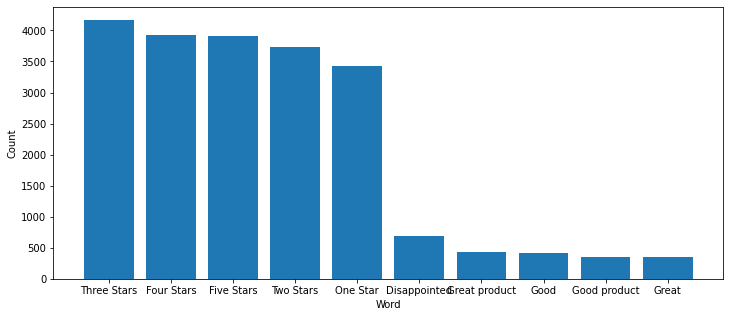

In [ ]:
import matplotlib.pyplot as plt

# The table of words and counts
table = {
    "Three Stars": 4169,
    "Four Stars": 3932,
    "Five Stars": 3918,
    "Two Stars": 3730,
    "One Star": 3435,
    "Disappointed": 683,
    "Great product": 437,
    "Good": 421,
    "Good product": 345,
    "Great": 345,
    "Poor quality": 336,
    "Ok": 327,
    "Nice": 300,
    "Meh": 290,
    "Cheap": 271,
    "Waste of money": 252,
    "Good quality": 235,
    "Cute": 235,
    "Perfect": 233,
    "Not worth it": 229
}

# Extract the words and counts from the table
words = list(table.keys())[:10]
counts = list(table.values())[:10]

# Create a new figure
fig = plt.figure(figsize=(12, 5))

# Add a subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the word counts as a bar chart
ax.bar(words, counts)


# Set the x-axis label
ax.set_xlabel("Word")

# Set the y-axis label
ax.set_ylabel("Count")


# Show the plot
plt.show()

We see some review titles have vastly more representation than others so we filter the dataset to only make it more balanced so the model does'nt overfit.

In [ ]:
# Again keep reveiews whose have review_length at least two words
amazon_dataset = amazon_dataset.filter(lambda example: len(example['review_title'].split(' ')) > 2)

  0%|          | 0/200 [00:00<?, ?ba/s]

We print out the features of the filtered dataset

In [ ]:
print(amazon_dataset)

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 125893
})


In [ ]:
def pick_examples(num):
  for i in range(0,num):
    print(amazon_dataset[random.randint(0,10000)])

pick_examples(4)

    review_id          product_id          reviewer_id  stars  \
0  en_0750653  product_en_0195985  reviewer_en_0572332      1   

                                         review_body  \
0  I bought this for my granddaughter and the mai...   

                                        review_title language product_category  
0  Piece Of Crap!! I Don't Recommend This Speaker...       en      electronics  
    review_id          product_id          reviewer_id  stars  \
0  en_0500577  product_en_0549519  reviewer_en_0279007      1   

                                         review_body  \
0  I still waiting for response from the vendor o...   

                                      review_title language product_category  
0  that’s why my review are like this, I not happy       en            other  
    review_id          product_id          reviewer_id  stars  \
0  en_0652596  product_en_0854300  reviewer_en_0293098      1   

                                         review_body  \
0  I 

Implementing the test train split for the dataset to split the dataset into test and train parts

In [ ]:
amazon_dataset = amazon_dataset.train_test_split(
    train_size=split_ratio, test_size=1-split_ratio
)

In [ ]:
# The respective test and train splts of the dataset

amazon_dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 113303
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 12590
    })
})

In [ ]:
# The number of rows in the training set

len(amazon_dataset["train"]["review_body"])

113303

Appending the Token "TL;DR" to training dataset as GPT-2 is a decoder only model, we need to append the review summary at the end of the main body of text and seperate them with a seperation token so, the model co differentiate between the review and summary.

In [ ]:
# Appending the Token "TL;DR" to training datset.

train_reviews = []
for i,j in zip(amazon_dataset["train"]["review_body"], amazon_dataset["train"]["review_title"]):
    train_reviews.append(i + " TL;DR " + j)

Example of the demarcation token between review and summary.

In [ ]:
# Example from the dataset.

train_reviews[999]

'Pattern is only on one side. The other side is plain gray fabric. Overall quality seems good though. TL;DR Fabric ony on one side.'

In [ ]:
#calculating the average length of the strings in the dataset.

average_length = sum([len(review.split()) for review in train_reviews])/len(train_reviews)
average_length

48.09609630812953

## Create baseline model

We create a baseline gpt-2 model to compare against the finetuned gpt-2 model. This forms our baseline model and shows how finetuning will effect the overall score and accuracy of the model.

In [ ]:
##loading a sample review into gpt2 and checking the summarized text 

GPT2_model_baseline = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2")
summarization_baseline_model  = GPT2_model_baseline(train_reviews[1], min_length=5)
print(summarization_baseline_model)

Horrible cracked within the first week TL;DR Don’t waste your money


In [ ]:
baseline_reviews = [review.split(" TL;DR ")[0] for review in random.sample(train_reviews, 3)]
baseline_reviews

["I ordered these to replace the 12 candelabra incandescent bulbs in our dinning room chandelier.. I ordered 12 and all but 1 worked. Within two weeks two more went bad so I ordered 3 more. It's been just about 1 year and three more have gone bad so I ordered 6 more. I thought the LED lamps were supposed to last thousands of hours but these don't and there is no warranty at all for these.",
 "Good quality medium weight T. Holds it's color in the wash. More muted tie dye was what I was looking for and this was perfect.",
 'There is no way to get it out unless you take a knife and slide it under the edge. It needs a handle or something']

In [ ]:
for rev in baseline_reviews:
    print("The Review body : ", rev)
    base_summary = GPT2_model_baseline(rev)
    print("the generated summary : ", base_summary)

The Review body :  I ordered these to replace the 12 candelabra incandescent bulbs in our dinning room chandelier.. I ordered 12 and all but 1 worked. Within two weeks two more went bad so I ordered 3 more. It's been just about 1 year and three more have gone bad so I ordered 6 more. I thought the LED lamps were supposed to last thousands of hours but these don't and there is no warranty at all for these.
the generated summary :  I ordered these to replace the 12 candelabra incandescent bulbs in our dinning room chandelier.. I ordered 12 and all but 1 worked. It's been just about 1 year and three more have gone bad so I ordered 6 more.
The Review body :  Good quality medium weight T. Holds it's color in the wash. More muted tie dye was what I was looking for and this was perfect.
the generated summary :  Good quality medium weight T. Holds it's color in the wash. More muted tie dye was what I was looking for and this was perfect.
The Review body :  There is no way to get it out unless 

As we can see from the generated summaries the baseline model is not very good it often repeats the entire review from the datset or does'nt produce any output, with minimal changes to the original sentence. The model needs to be trained on the task of summarizaion to produce actual meaningful summaries.

### Create model parameters and tokenize dataset 

In [ ]:
# Define the hyperparameters of the model

params = gpt2_model.parameters()
torch_optimizer = optim.Adamax(params, lr=2e-5)

In [ ]:
gpt2_tokenizer.encode(" TL;DR ")

[24811, 26, 7707, 220]

In [ ]:
length_tldr_token = len(gpt2_tokenizer.encode(" TL;DR "))
length_tldr_token

4

In [ ]:
class CreateAmazonDataset(Dataset):
    def __init__(self, review_dataset, gpt2_tokenizer, max_length, length_tldr_token):
        self.max_length = max_length
        self.gpt2_tokenizer = gpt2_tokenizer
        self.end_of_sequence = self.gpt2_tokenizer.eos_token
        self.end_of_sequence_id = self.gpt2_tokenizer.eos_token_id
        self.review_dataset = review_dataset
        self.processed_data = []
    
        for data in self.review_dataset:
            # Add end_of_sequence i.e. "tl;dr" token at the end of each tokenized_review body.
            tokenized_review = self.gpt2_tokenizer.encode(data + self.end_of_sequence)
            
            # adjust tokenised data accordingly
            len_token_tokenized_review = len(tokenized_review) - length_tldr_token
            if len_token_tokenized_review > self.max_length:        # truncate
                processed_data = tokenized_review[:self.max_length + 3]+[self.end_of_sequence_id] 
            elif len_token_tokenized_review < self.max_length:      # pad
                difference = self.max_length - len_token_tokenized_review
                processed_data = tokenized_review + [self.end_of_sequence_id] * difference
            else:
                processed_data = tokenized_review

            # Append final data
            self.processed_data.append(torch.tensor(processed_data))

    def __len__(self):
        return len(self.processed_data)


    def __getitem__(self, item):
        return self.processed_data[item]

In [ ]:
# Call the above function to tokenize the datset to feed into the torch dataloader

torch_data = CreateAmazonDataset(train_reviews, gpt2_tokenizer, max_length, length_tldr_token)


In [36]:
len(torch_data)

113303

In [ ]:
#defining the dataloader to input our data

torch_data_loader = DataLoader(torch_data, batch_size=dataset_batch, shuffle=True, drop_last=True)

In [ ]:
#scheduler = torch.optim.lr_scheduler.ExponentialLR(torch_optimizer, gamma=0.9)

def train_summarizer(gpt2_model, torch_optimizer, data_loader, epochs):    
    for epoch in range(epochs):
        for _index, batch in enumerate(data_loader):
            with torch.set_grad_enabled(True):
                torch_optimizer.zero_grad()
                batch = batch.to(device)
                output = gpt2_model(batch, labels=batch)
                loss = output[0]
                loss.backward()
                torch_optimizer.step()
                if _index % 100 == 0:
                    #print("loss: %f, %d"%(loss, _index))
                    print(f"Batch id : {_index}, loss : {loss}")
        #scheduler.step()
            

In [ ]:
train_summarizer(gpt2_model=gpt2_model, 
                torch_optimizer=torch_optimizer, 
                data_loader=torch_data_loader, 
                epochs=1)

Batch id : 0, loss : 9.414424896240234
Batch id : 100, loss : 1.4090213775634766
Batch id : 200, loss : 1.5880990028381348
Batch id : 300, loss : 1.4059460163116455
Batch id : 400, loss : 1.4563990831375122
Batch id : 500, loss : 1.6765925884246826
Batch id : 600, loss : 1.5246212482452393
Batch id : 700, loss : 1.4704519510269165
Batch id : 800, loss : 1.1666969060897827
Batch id : 900, loss : 1.485956072807312
Batch id : 1000, loss : 1.3270219564437866
Batch id : 1100, loss : 1.8242977857589722
Batch id : 1200, loss : 1.4496041536331177
Batch id : 1300, loss : 1.5219169855117798
Batch id : 1400, loss : 1.318770408630371
Batch id : 1500, loss : 1.4649665355682373
Batch id : 1600, loss : 1.6321691274642944
Batch id : 1700, loss : 1.3775383234024048
Batch id : 1800, loss : 1.233543038368225
Batch id : 1900, loss : 1.0585871934890747
Batch id : 2000, loss : 1.3455029726028442
Batch id : 2100, loss : 1.2103222608566284
Batch id : 2200, loss : 1.3597973585128784
Batch id : 2300, loss : 1.4

In [ ]:
# Saving the model weights, so we dont have to train the model again and again while running it

torch.save(gpt2_model.state_dict(), "gpt2_model.pth")
print("Saved PyTorch Model State to gpt2_model.pth")

Saved PyTorch Model State to gpt2_+model.pth


In [37]:
# loads the saved model

model = gpt2_model
model.load_state_dict(torch.load("gpt2_model.pth"))

<All keys matched successfully>

In [38]:
from torch import softmax, topk, sum, tensor
def topk_tokenids(probs, n=9):
    # scores to probabilities
    probabilities = softmax(probs, dim= -1)
    
    tokens_probabilities, top_indices = topk(probabilities, k=n)

    tokens_probabilities = tokens_probabilities / sum(tokens_probabilities)

    tokens_probabilities = tokens_probabilities.cpu().detach().numpy()

    rand_prob = np.random.choice(n, 1, p = tokens_probabilities)
    tokenId = top_indices[rand_prob][0]

    return int(tokenId)

In [39]:
def gpt2_model_infer(gpt2_model, gpt2_tokenizer, review, max_length=15):

    review_encoded = gpt2_tokenizer.encode(review)
    result = review_encoded
    initial_input = tensor(review_encoded).unsqueeze(0).to(device)

    with torch.set_grad_enabled(False):

        output = gpt2_model(initial_input)

        logits = output.logits[0,-1]

        result.append(topk_tokenids(logits))

        for _ in range(max_length):
            
            input = tensor(result).unsqueeze(0).to(device)
            output = gpt2_model(input)
            logits = output.logits[0,-1]
            res_id = topk_tokenids(logits)

            if res_id == gpt2_tokenizer.eos_token_id:
                return gpt2_tokenizer.decode(result)
            else: 
                result.append(res_id)
                
    # IF no EOS is generated, return after the max_len
    return gpt2_tokenizer.decode(result)

In [40]:
few_reviews = [review.split(" TL;DR ")[0] for review in random.sample(train_reviews, 5)]
few_reviews

['My husband bought this for me and I am inlove with it. It is very easy to use and simple. It has a strap when recording that makes it comfortable to use.',
 "The product works well without the smell. I suspect shoe cleaner will be needed at some point on the scuffs, but after two weeks of keeping the shoes clean and conditioned greatly reduces the polishing required, haven't polished them yet and don't need to. Shoe shine service can work for the rest. Would have been a 5 but the brush is useless in my opinion. Better off getting a small kitchen scrub brush with a handle and bristles at the end, easier to use and gets in the hard to get to places better. Product is being used on black shoe with a glossy shine, that are worn almost every day in the construction industry.",
 'thought they would be a tad bigger in size... but a great value .. they are a xmas present..',
 "It works but it's more bulky than it should be and magnets are way too strong. Every time you have to close the door

In [41]:
for review in few_reviews:
    summaries = set()
    print("The Review body : ", review)
    while len(summaries) < 3:
        summary = gpt2_model_infer(gpt2_model, gpt2_tokenizer, review + " TL;DR ").split('TL;DR')[1].strip()
        print("the generated summary : ", summary)
        if summary not in summaries:
            summaries.add(summary)

The Review body :  My husband bought this for me and I am inlove with it. It is very easy to use and simple. It has a strap when recording that makes it comfortable to use.
the generated summary :  !!!!!!
the generated summary :  !!! I Love My Brother!
the generated summary :  ive loved it for a while now and my husband is using it
The Review body :  The product works well without the smell. I suspect shoe cleaner will be needed at some point on the scuffs, but after two weeks of keeping the shoes clean and conditioned greatly reduces the polishing required, haven't polished them yet and don't need to. Shoe shine service can work for the rest. Would have been a 5 but the brush is useless in my opinion. Better off getting a small kitchen scrub brush with a handle and bristles at the end, easier to use and gets in the hard to get to places better. Product is being used on black shoe with a glossy shine, that are worn almost every day in the construction industry.
the generated summary : 

In [42]:
# Add rogue score

# Test data rouge score

In [43]:
from rouge import Rouge

In [44]:
test_reviews = amazon_dataset["test"]["review_body"]

Genreating the baseline summaries using the baseline model

In [110]:
test_gen_summaries = []

for review in test_reviews[:20]:
    summary = GPT2_model_baseline(review, min_length=10)
    summary = summary.split('.')[0]
    test_gen_summaries.append(summary)

Generating the summaries using the finetuned model

In [111]:
test_generated_summaries = []

for review in test_reviews[:100]:
    summary = gpt2_model_infer(gpt2_model, gpt2_tokenizer, review + " TL;DR ").split('TL;DR')[1].strip()
    test_generated_summaries.append(summary)

In [136]:
test_generated_summaries[:5]

['ive been using earbuds for 6 weeks',
 'icky clippers are not as sharp as they look',
 'ive had these for a while now',
 'ive been using this as a replacement for my iPhone 7',
 'ive been looking for a guest bed for years']

In [113]:
# cleaning up the generated summaries tokens
import re

indices_to_remove = []
# The regular expression pattern to match
pattern = r"^[A-Za-z][\w\s]+$"

# The list of strings to match against the pattern


# Compile the regular expression pattern
regex = re.compile(pattern)

# Loop through the strings and match each one against the pattern
for _index,value in enumerate(test_generated_summaries):
    # Check if the string matches the pattern
    match = regex.match(value)
    # If the string matches the pattern, print it
    if match:
      print(value)
    else:
        indices_to_remove.append(_index)

gpt2_summary = test_gen_summaries
baseline_summaries = test_generated_summaries
actual_s = amazon_dataset["test"]["review_title"]
actual_summaries = actual_s[:100]

for i in sorted(indices_to_remove, reverse=True):
    del baseline_summaries[i]
    del actual_summaries[i]

ive been using earbuds for 6 weeks
icky clippers are not as sharp as they look
ive had these for a while now
ive been using this as a replacement for my iPhone 7
ive been looking for a guest bed for years
ive been getting a lot of compliments
ive been using these winchs for years
ive worn it for a month now
ive had to deal with the glue
icky fit but good grip
icky and not sharp
ive had no problems installing with no problems other than the brake lever screw hole for
iphone clip broke while trying to get the phone out
ive bought this rug for a dog but I wouldnt buy again
icky fit and poor construction
ive been stuck with a defective item
ive only received a single product
ive only received 12 colors
ive been using it a month and i have had a bad experience
ive only received this one time
Not as good as pictured
icky and cheap


In [114]:
## the generated summaries from the GPT-2 code

#gen_summaries

In [115]:
# actual summaries in the test data

#actual_summaries

In [116]:
## Converting the actual summaries into a list to evaluate the model

act_summ = []
for summ in actual_summaries:
    act_summ.append(summ)
type(actual_summaries)
type(act_summ)

list

In [135]:
## checking if both the lists have same number of ntries before generating score
len(baseline_summaries) == len(act_summ)

True

Generating the rouge score for the baseline model

In [128]:
rouge = Rouge()

baseline_scores = rouge.get_scores(baseline_summaries, act_summ, avg=True)

In [129]:
print("Baseline Rouge scores : ")
for key, value in baseline_scores.items():
    print(key , ": ",  value)

Baseline Rouge scores : 
rouge-1 :  {'r': 0.09208972845336483, 'p': 0.10296143250688705, 'f': 0.09437472739108776}
rouge-2 :  {'r': 0.02929292929292929, 'p': 0.0349025974025974, 'f': 0.031105168674835745}
rouge-l :  {'r': 0.08416961826052737, 'p': 0.09558244785517513, 'f': 0.08678579458476367}


In [130]:
test_summaries = []
for reviews in test_reviews[:20]:
    test_summaries.append(reviews)

Generating the rouge score for the finetuned model summaries

In [131]:
finetuned_score  = rouge.get_scores(gpt2_summary, test_summaries, avg=True)

In [132]:
print("Test Rouge scores : ")
for key, value in finetuned_score.items():
    print(key , ": ",  value)


Test Rouge scores : 
rouge-1 :  {'r': 0.49089865016717227, 'p': 1.0, 'f': 0.6080606131177506}
rouge-2 :  {'r': 0.45395892928268466, 'p': 0.9954545454545455, 'f': 0.5676764179673615}
rouge-l :  {'r': 0.49089865016717227, 'p': 1.0, 'f': 0.6080606131177506}
